# Article figures notebook
This notebook contains the code to reproduce the figures included in the article.

In [46]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm

from pseudobatch import pseudobatch_transform, pseudobatch_transform_pandas, pseudobatch_transform_pandas_by_group
from pseudobatch.datasets._dataloaders import _prepare_simulated_dataset

In [47]:
FIGURES_DIR = pathlib.Path('../figures')
FIGURE_HEIGHT = 3. # inches
PAGE_WIDTH = 6.1 # inches
FIG_A_WIDTH = PAGE_WIDTH * 0.6 
FIG_B_WIDTH = PAGE_WIDTH * 0.4

mpl.rcParams['figure.constrained_layout.use'] = True

## Figure 1A

In [48]:
# Here we do not use the datasets stored in the package.
# Instead we import the dataset from the article/data folder, 
# this makes sure if the simulations are rerun the new data is used
data_path = pathlib.Path('../data/standard_fed-batch_process.csv')
fedbatch_df = _prepare_simulated_dataset(data_path)

We will make a seperate dataframe that contains on the measurements at the sampling time points.

In [49]:
fedbatch_df_measurements_only = (fedbatch_df
    .query('sample_volume > 0')
    .copy()
    .reset_index(drop=True)
)

We will start by fitting a log-linear model to the non-transformed biomass data in mass units (`m_Biomass`).

$$
log(m_{Biomass}) = a + \mu * t
$$

In [50]:
y, X_noncorrected = dmatrices(formula_like = "np.log(m_Biomass) ~ timestamp", data= fedbatch_df_measurements_only)
model_noncorrected = sm.OLS(endog=y, exog=X_noncorrected)
res_noncorrected = model_noncorrected.fit()
mu_hat_noncorrected = res_noncorrected.params[1]
y_pred_noncorrected = res_noncorrected.predict(X_noncorrected)
print(mu_hat_noncorrected)

0.06597174185227486


The simulated fed-batch culture has a target growth rate of 0.1, thus the estimate based on the non-transformed data is wrong.

# Calculate the growth rate using the pseudo batch transformation

Now we can calculate the corrected biomass using the pseudo batch transformation

In [51]:
fedbatch_df["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df["sample_volume"].fillna(0).to_numpy(),
)
fedbatch_df_measurements_only["c_Biomass_pseudo"] = pseudobatch_transform(
    measured_concentration=fedbatch_df_measurements_only["c_Biomass"].to_numpy(),
    reactor_volume=fedbatch_df_measurements_only["v_Volume"].to_numpy(),
    accumulated_feed=fedbatch_df_measurements_only["v_Feed_accum"].to_numpy(),
    concentration_in_feed=0,
    sample_volume=fedbatch_df_measurements_only["sample_volume"].fillna(0).to_numpy(),
)

Now we use a linear model to fit the growth rate using the pseudo concentrations.

$$
log(C^{\star}_{Biomass}) = a + \mu * t
$$

In [52]:
y, X_corrected = dmatrices(formula_like = "np.log(c_Biomass_pseudo) ~ timestamp", data= fedbatch_df_measurements_only)
model_corrected = sm.OLS(endog=y, exog=X_corrected)
res_corrected = model_corrected.fit()
mu_hat_corrected = res_corrected.params[1]
print("Fitted growth rate from corrected biomass: " + str(res_corrected.params[1]))

Fitted growth rate from corrected biomass: 0.10000016643815146


The pseudo concentrations and the raw mass measurements are in different numerical scales. This means that when plotted together on the same axis it is not easy to interpret. For visualization purposes we can multiply the pseudo concentrations by the initial reactor volume this scales the pseudo concentrations to a numerical scale that is comparable with the non-transformed mass measurements.

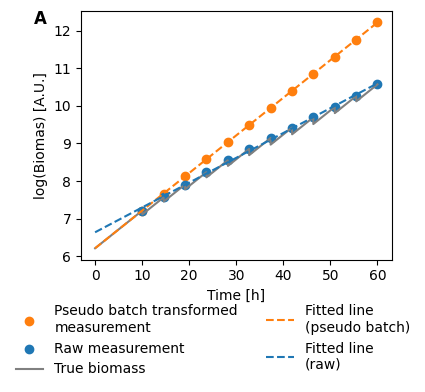

In [53]:
## plot the data and the fitted line
initial_volume = fedbatch_df_measurements_only["v_Volume"].iloc[0]
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['c_Biomass_pseudo'].multiply(initial_volume).transform(np.log), label='Pseudo batch transformed\nmeasurement', color = "C1")
plt.scatter(fedbatch_df_measurements_only['timestamp'], fedbatch_df_measurements_only['m_Biomass'].transform(np.log), label='Raw measurement', color = "C0")
plt.plot(fedbatch_df['timestamp'], fedbatch_df['m_Biomass'].transform(np.log), label='True biomass', color='grey')

# Drawing linear regression line
x_pred = sm.add_constant(fedbatch_df['timestamp']) 
# The model predicts log(c_Biomass_pseudo) and we want to plot log(c_Biomass_pseudo * initial_volume), thus we add log(initial_volume) to the prediction
y_pred_pseudo = res_corrected.predict(x_pred) + np.log(initial_volume) 
y_pred_raw = res_noncorrected.predict(x_pred) 
plt.plot(fedbatch_df['timestamp'], y_pred_pseudo, color='C1', linestyle = 'dashed', label='Fitted line\n(pseudo batch)')
plt.plot(fedbatch_df['timestamp'], y_pred_raw, color='C0', linestyle = 'dashed', label='Fitted line\n(raw)')
plt.ylabel("log(Biomas) [A.U.]")
plt.xlabel("Time [h]")
plt.savefig(FIGURES_DIR / "transformed_and_non-transformed_logscale.png", dpi=300)

# resize height and width of figure
fig_simulated = plt.gcf()

# add legend and text 
# the artist are stored in variable to be able to pass them to the savefig function
text = fig_simulated.text(0.01, 0.99, 'A', fontsize=12, fontweight='bold', va='top', ha='left')
lgd = fig_simulated.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncols=2, borderaxespad=0., frameon=False)

fig_simulated.set_size_inches((FIG_A_WIDTH, FIGURE_HEIGHT))
fig_simulated.savefig(
    FIGURES_DIR / "transformed_and_non-transformed_logscale_paper.png", 
    dpi=300,
    bbox_extra_artists=(lgd,text), 
    bbox_inches='tight',
)

Finally, we inspect the fitted and true growth rates.

In [54]:
print("Fitted growth rate from pseudo batch transformed biomass: " + str(res_corrected.params[1]))
print("Fitted growth rate from raw biomass: " + str(res_noncorrected.params[1]))
print("True simulated growth rate " + str(fedbatch_df_measurements_only["mu_true"].iloc[-1]))

Fitted growth rate from pseudo batch transformed biomass: 0.10000016643815146
Fitted growth rate from raw biomass: 0.06597174185227486
True simulated growth rate 0.1000104046529978


## Figure 1B

In [55]:
real_world_df = pd.read_csv("../real_world_data/biolector_yeast_fedbatch.csv")
real_world_df.columns

Index(['Strain', 'Biolector well', 'Biolector column', 'Biolector row',
       'Cycle', 'Time', 'Feeding time', 'Volume', 'Accum. feed [uL]',
       'Biomass concentration [light scatter]', 'DO%', 'Sample volume'],
      dtype='object')

In [56]:
biomass_concentration_in_feed = 0 # There is no yeast cells in the feed medium

# Apply pseudobatch transformation and save the transformed biomass concentration in a new column
real_world_df[["Biomass pseudo concentration"]] = pseudobatch_transform_pandas_by_group(
    real_world_df,
    groupby_cols=["Biolector well"], # we want to apply the pseudobatch transformation to each culture (Biolector well)
    measured_concentration_colnames=["Biomass concentration [light scatter]"], # we wish to transform the biomass concentration measurements
    reactor_volume_colname='Volume',
    accumulated_feed_colname='Accum. feed [uL]',
    concentration_in_feed=[biomass_concentration_in_feed],
    sample_volume_colname='Sample volume',
)

To be able to the visualize the mass removal through sampling we will need to plot the data in a mass equivalent unit. Because the light scatter measurements are proportional to the biomass concentration, then we can multiply the light scatter measurements by the reactor volume to get a number that is proportional to the biomass in mass. We call this variable `Light scatter mass`. 

Again we need to do the scaling trick described above to scale the pseudo concentration to get it into a comparable numerical scale.

In [57]:
real_world_df['Light scatter mass'] = real_world_df['Biomass concentration [light scatter]'] * real_world_df['Volume']
real_world_df['Light scatter mass pseudo'] = real_world_df['Biomass pseudo concentration'] * real_world_df['Volume'].iloc[0]

To simplify the visualization we only show parts of the data in the article. Therefore the data is subset before plotting. 

/var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/ipykernel_20538/1021513913.py:23: UserWarning: The figure layout has changed to tight
  fig_real_world.tight_layout()


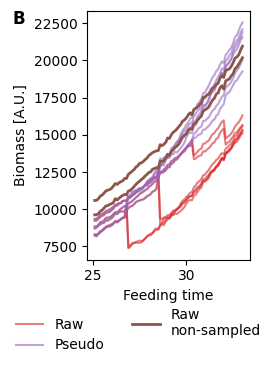

In [60]:
use_columns = [1, 2]
plot_dat = (real_world_df
    .query("`Feeding time` > 25 &  `Feeding time` < 33 & `Biolector column`.isin(@use_columns)")
)

sns.lineplot(data=plot_dat.query("`Biolector row` != 'F'"), x='Feeding time', y='Light scatter mass', units='Biolector well', estimator=None, color='C3', alpha=0.6, label='Raw')
sns.lineplot(data=plot_dat.query("`Biolector row` != 'F'"), x='Feeding time', y='Light scatter mass pseudo', units='Biolector well', estimator=None, color='C4', alpha=0.6, label='Pseudo')
sns.lineplot(data=plot_dat.query("`Biolector row` == 'F'"), x='Feeding time', y='Light scatter mass', units='Biolector well', estimator=None, color='C5', linewidth = 2, label='Raw\nnon-sampled')

# drop duplicated labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
# drop legend
plt.legend().remove()
plt.ylabel('Biomass [A.U.]')
plt.savefig(FIGURES_DIR / 'real-data-compare.png', dpi=300)

fig_real_world = plt.gcf()
# add label to top left corner
lgd = fig_real_world.text(0.01, 0.99, 'B', fontsize=12, fontweight='bold', va='top', ha='left')
text = fig_real_world.legend(by_label.values(), by_label.keys(), loc="lower left", bbox_to_anchor=(0., -0.17), ncols=2, borderaxespad=0., frameon=False)
fig_real_world.set_size_inches((FIG_B_WIDTH, FIGURE_HEIGHT))
fig_real_world.tight_layout()
fig_real_world.savefig(FIGURES_DIR / 'real-data-compare-paper.png', dpi=300, bbox_extra_artists=(lgd,text), bbox_inches='tight')

/var/folders/z6/mxpxh4k56tv0h0ff41vmx7gdwtlpvp/T/ipykernel_20538/1544315730.py:7: UserWarning: The figure layout has changed to tight
  fig_combined.tight_layout()


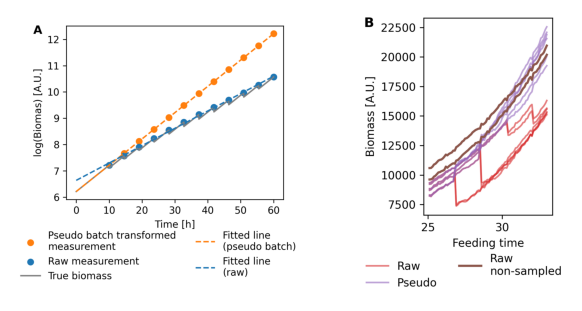

In [59]:
import matplotlib.image as mpimg
fig_combined, axes = plt.subplots(1, 2, figsize=(PAGE_WIDTH, FIGURE_HEIGHT))
axes[0].set_axis_off()
axes[0].imshow(mpimg.imread(FIGURES_DIR / 'transformed_and_non-transformed_logscale_paper.png'))
axes[1].set_axis_off()
axes[1].imshow(mpimg.imread(FIGURES_DIR  / 'real-data-compare-paper.png'))
fig_combined.tight_layout()